In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import scipy
from scipy import stats 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import *
import matplotlib.colors as colors
import openpyxl
from netCDF4 import Dataset
import h5netcdf

In [2]:
sourceData='/bettik/amoryc/MARout/GRa/spin2/work/'
variable='TT' ##RF;SF;SHSN3;TT
fileNameM='mon-TT-MARv3.14_ER5-2000-2023.nc' ##change to monthly
dsM= xr.open_dataset(sourceData+fileNameM)['TT']

In [3]:
## Model MAR
sourceDataGrid='/home/amoryc/'
#fileName_grF='NST.2000.01.01.00.GRa_Fedchenko.nc'
fileName_grM='NST.2000.01.01.00.GRa_Mera.nc_ICEmask'
ds_grM= xr.open_dataset(sourceDataGrid+fileName_grM)

In [4]:
#Gra Mera 5km
sourceData='/bettik/amoryc/MARout/GRa/spin2/work/'
variable='TT' ##RF;SF;SHSN3;TT
fileNameM='mon-TT-MARv3.14_ER5-2000-2023.nc' ##change to monthly
dsM= xr.open_dataset(sourceData+fileNameM)['TT'][:,0,:,:] ## montlhy mean

In [5]:
###
#AWS-Mera La: Since November 2013 (AWS inserted on firm rocks – off-glacier)
#Location in WGS84, Lat: 27.735°N; Long: 86.900°E; Elevation: 5352.008 m 
#or UTM Zone 45; Easting: 490137.007 m; Northing: 3067850.613 m on 22/11/2020
###
lon_Naulek=86.89739046
lat_Naulek=27.71772341
elev_Naulek=5350.000
##Find the pixel of MAR corresponding to station
target_lon = lon_Naulek
target_lat = lat_Naulek
lon=ds_grM.LON
lat=ds_grM.LAT

In [6]:
#Step 2: Find the nearest grid point to target_lon,target_lat
# Compute distance to each grid point
dist = np.sqrt((lon - target_lon)**2 + (lat - target_lat)**2)
print(dist)
j, i = np.unravel_index(dist.argmin(), dist.shape)

<xarray.DataArray (y: 116, x: 164)> Size: 76kB
array([[5.279424 , 5.232181 , 5.184988 , ..., 3.5881248, 3.631921 ,
        3.6758704],
       [5.265635 , 5.21825  , 5.1709113, ..., 3.566808 , 3.610866 ,
        3.6551087],
       [5.252194 , 5.2046523, 5.1571703, ..., 3.5459263, 3.590265 ,
        3.6347723],
       ...,
       [6.09539  , 6.0520864, 6.0089116, ..., 4.6114783, 4.647657 ,
        4.6841164],
       [6.1210732, 6.0779243, 6.034923 , ..., 4.644426 , 4.6803765,
        4.7166038],
       [6.1469765, 6.103999 , 6.061146 , ..., 4.6775894, 4.713296 ,
        4.7493043]], shape=(116, 164), dtype=float32)
Coordinates:
  * x        (x) float32 656B -495.0 -490.0 -485.0 -480.0 ... 310.0 315.0 320.0
  * y        (y) float32 464B -195.0 -190.0 -185.0 -180.0 ... 370.0 375.0 380.0


In [7]:
print(j,i)

39 99


In [8]:
#Step 3: Extract data at that location
# For a single time step
#value = dsM['SH'].isel(y=j, x=i)
## If there's a time dimension
dsM_sta=dsM[0:, i, j]
dsM_sta_new2= dsM_sta.rename({'TIME': 'time'})
#units=dsM.units
dsM_sta_new= dsM_sta_new2.where(dsM_sta_new2.values <= 70)
#dsM_sta_new.values


In [9]:
####
## Opening station data
####

In [10]:
path="/bettik/PROJECTS/pr-regional-climate/santolam/glacioclim/donnees_meteo/Naulekfinal2012_24.xlsx"
xl_data=pd.ExcelFile(path)                           
#print(xl_data)  

In [11]:
df= {sheet_name: xl_data.parse(sheet_name)     
       for sheet_name in xl_data.sheet_names}
Data=df['Naulekfinal2012_24']                  
NameVars=['Time','Tairlow','RHlow','Tairhight','RHhight','u','Direction','SWin','SWout','LWincor','LWoutcor','Abl/acc dist sensor surf','tilt metter XAXIS','tilt meter YAXIX']
UnitVars=['data/hour','C','%','C','%','m/s','degrees','W/m2','W/m2','W/m2','W/m2','m','degrees','degrees']

##Define new DataFrame and changing name of columns
dfile= pd.DataFrame(data=Data.loc[4:]) 
df=pd.DataFrame(dfile.values, columns=NameVars) 
### Opening one column + converting into an array
Tairlow_ar=[float(i) for i in df.Tairlow.values]   #Convertit les données en float utilisables 
Tairhight_ar=[float(i) for i in df.Tairhight.values] 

In [12]:
#Pour l'utilisation des données avec xarray, redéfinitions des variables en prenant en compte la fréquence à laquelle les données sont prises ( ici 30 min ) 
def NewTime(
        NameVar,
        Var_ar,
        freq):
    start, end = df.Time.values[0], df.Time.values[-1]
    time = pd.date_range(start, end, freq=freq)
    ds = xr.Dataset({NameVar: ("time",np.asarray(Var_ar)), "time": time})
    return ds 
    
Tlow=NewTime('Tairlow',Tairlow_ar,'30min')
Thight=NewTime('Tairhight',Tairhight_ar,'30min')
T=xr.Dataset()
T['Tair']= ((Tlow.Tairlow+Thight.Tairhight)/2) #faire égal à ça si différent de Nan et égal à Tlow sinon.

In [13]:
T

<xarray.Dataset> Size: 3MB
Dimensions:  (time: 210344)
Coordinates:
  * time     (time) datetime64[ns] 2MB 2012-11-27T12:30:00 ... 2024-11-26T16:...
Data variables:
    Tair     (time) float64 2MB -5.92 -5.713 -5.636 -5.785 ... nan nan nan nan

In [14]:
daily_meanT=T.resample(time='D').mean()                          #Utilisation de la librairie xarray maintenant possible car les données ont une forme bien définie
monthly_meanT=daily_meanT.resample(time='ME').mean()             # chaque variable ici défini est un xarray.Dataset
yearly_meanT=monthly_meanT.resample(time='YE').mean()
#daily_meanTM

In [15]:
#Définition des Saisons, et création d'une fonction qui définit les saisons en fonction des périodes des moussons:
seasons = {
	'MAM': [3, 4, 5],  	
	'JJAS': [6, 7, 8, 9],  
	'ON': [10, 11],    	
	'DJF': [12, 1, 2]  	
}
def seasonsdata(ds, season_name):  #monthly_meanTM.sel(time=monthly_meanTM['time'].dt.month.isin(seasons['MAM'])). Sélectionne dans le dataset les mois correspondants aux saisons définies au dessus

	x = seasons[season_name]
	return ds.sel(time=ds['time'].dt.month.isin(x))


In [16]:
# Get the time coordinates CORRIGER DIFF ENTRE MAR ET STATION
time1 = monthly_meanT['time']# début 2013-11-15 fin 2024-11-28
time2 = dsM_sta_new['time'] # début 2003-01-01T12: fin 2013-12-31T12
start=time1[0] 
end=time2[-1]

In [17]:
ts_sta=monthly_meanT.sel(time=slice(start,end))
ts_MAR=dsM_sta_new.sel(time=slice(start,end))

In [18]:
Tsta_monthly_cycle=monthly_meanT.groupby('time.month').mean()
TMAR_monthly_cycle=dsM_sta_new.groupby('time.month').mean()

In [19]:
Tsta_premon = seasonsdata(monthly_meanT, 'MAM').groupby('time.month').mean()

Tsta_mon = seasonsdata(monthly_meanT, 'JJAS').groupby('time.month').mean()

Tsta_postmon =  seasonsdata(monthly_meanT, 'ON').groupby('time.month').mean()

Tsta_hiver  = seasonsdata(monthly_meanT, 'DJF').groupby('time.month').mean()


In [20]:
#dsM_sta_new
TMAR_premon = seasonsdata(dsM_sta_new, 'MAM').groupby('time.month').mean()

TMAR_mon = seasonsdata(dsM_sta_new, 'JJAS').groupby('time.month').mean()

TMAR_postmon =  seasonsdata(dsM_sta_new, 'ON').groupby('time.month').mean()

TMAR_hiver  = seasonsdata(dsM_sta_new, 'DJF').groupby('time.month').mean()

In [21]:
#Time series annual data sta
Timeseries_Tsta_premon = seasonsdata(ts_sta, 'MAM').resample(time='YE').mean() # T moyen de chaque saison 
Timeseries_Tsta_mon = seasonsdata(ts_sta, 'JJAS').resample(time='YE').mean()
Timeseries_Tsta_postmon =  seasonsdata(ts_sta, 'ON').resample(time='YE').mean()
Timeseries_Tsta_hiver  = seasonsdata(ts_sta, 'DJF').resample(time='YE').mean()

In [22]:
#dsM_sta_new


TMAR_premon = seasonsdata(ts_MAR, 'MAM').groupby('time.month').mean()

TMAR_mon = seasonsdata(ts_MAR, 'JJAS').groupby('time.month').mean()

TMAR_postmon =  seasonsdata(ts_MAR, 'ON').groupby('time.month').mean()

TMAR_hiver  = seasonsdata(ts_MAR, 'DJF').groupby('time.month').mean()





In [23]:
#Time series annual data MAR 
Timeseries_TMAR_premon = seasonsdata(ts_MAR, 'MAM').resample(time='YE').mean() # T moyen de chaque saison 
Timeseries_TMAR_mon = seasonsdata(ts_MAR, 'JJAS').resample(time='YE').mean()
Timeseries_TMAR_postmon =  seasonsdata(ts_MAR, 'ON').resample(time='YE').mean()
Timeseries_TMAR_hiver  = seasonsdata(ts_MAR, 'DJF').resample(time='YE').mean()


In [24]:
xtime15_24=np.arange(2013,2023+1,1)
xtime14_24=np.arange(2012,2023+1,1)

In [25]:
#Régression linéaire Station Data
linTsta_premon= stats.linregress(xtime15_24,Timeseries_Tsta_premon['Tair'].values)
linTsta_mon  = stats.linregress(xtime15_24,Timeseries_Tsta_mon['Tair'].values)
linTsta_postmon= stats.linregress(xtime14_24,Timeseries_Tsta_postmon['Tair'].values)
linTsta_hiver = stats.linregress(xtime14_24,Timeseries_Tsta_hiver['Tair'].values)

In [26]:
#Régression linéaire MAR Data
linTMAR_premon=stats.linregress(xtime15_24,Timeseries_TMAR_premon.values)
linTMAR_mon=stats.linregress(xtime15_24,Timeseries_TMAR_mon.values)
linTMAR_postmon=stats.linregress(xtime15_24,Timeseries_TMAR_postmon.values)
linTMAR_hiver=stats.linregress(xtime14_24,Timeseries_TMAR_hiver.values)

In [27]:
#T MAR Corrected for [elevation / Hight ? ]
#Evaluer la différence de hauteur entre la station et le niveau 1 de la grille MAR considérée
SH_sta=elev_Naulek
value = ds_grM['SH'].isel(y=j, x=i)
diff=(SH_sta-value.values)
Hcorr=diff*0.001
print(value.values,SH_sta,diff)


TMAR_corrected_premon = TMAR_premon+(-5.9*Hcorr)

TMAR_corrected_mon = TMAR_mon+(-5.1*Hcorr)

TMAR_corrected_postmon =  TMAR_postmon+(-5.3*Hcorr)

TMAR_corrected_hiver  = TMAR_hiver+(-4.7*Hcorr)


TMAR_monthly_cycle_corrected = TMAR_monthly_cycle+(-5.2*Hcorr)


5064.1274 5350.0 285.87256


285.87256


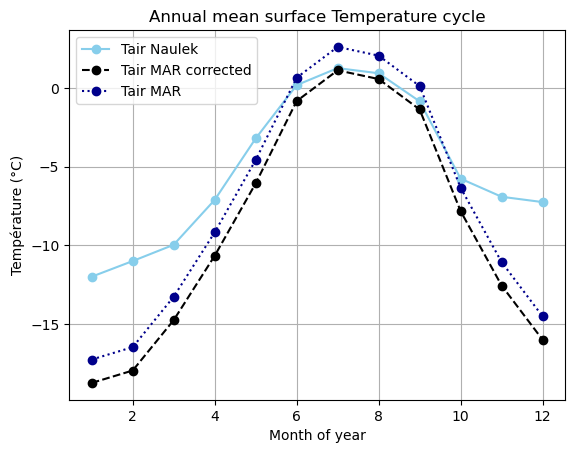

In [28]:
#Monthly cycle

plt.plot(Tsta_monthly_cycle.month,Tsta_monthly_cycle.Tair,
    color='skyblue',linestyle='-',label='Tair Naulek',marker='o')
plt.plot(TMAR_monthly_cycle_corrected.month,TMAR_monthly_cycle_corrected.values,
    color='black',linestyle='--',label='Tair MAR corrected',marker='o')
plt.plot(TMAR_monthly_cycle.month,TMAR_monthly_cycle.values,
    color='darkblue',linestyle=':',label='Tair MAR',marker='o')
plt.legend()
plt.title('Annual mean surface Temperature cycle')
plt.xlabel('Month of year')
plt.ylabel('Température (°C)')

plt.grid(True)
print(diff)

#Ajout incertitudes, 

fig, ((ax1,ax2) , (ax3,ax4)) = plt.subplots(2,2, figsize=(20,16))
ax1.plot(Tsta_premon.month, Tsta_premon['Tair'].values, linestyle=':', marker= 'o', label='Tair Station MeraNaulek')
ax1.plot(TMAR_premon.month, TMAR_premon.values, linestyle=':', marker= 'o', label='Tair MAR')
ax1.plot(TMAR_corrected_premon.month, TMAR_corrected_premon.values, linestyle=':', marker= 'o', label='Tair MAR corrected')

ax1.legend(bbox_to_anchor=(0.1, 0.5, 0.5, 0.5)) 
ax1.set_title('MAM')
ax1.set_xlabel('Month')
ax1.set_ylabel('Température (°C)')
ax1.grid()

ax2.plot(Tsta_mon.month, Tsta_mon['Tair'].values, linestyle=':', marker= 'o', label='Tair Station MeraNaulek')
ax2.plot(TMAR_mon.month, TMAR_mon.values, linestyle=':', marker= 'o', label='Tair')
ax2.plot(TMAR_corrected_mon.month, TMAR_corrected_mon.values, linestyle=':', marker= 'o', label='Tair MAR corrected')

ax2.set_title('JJAS')
ax2.set_xlabel('Month')
ax2.set_ylabel('Température (°C)')
ax2.grid()

ax3.plot(Tsta_postmon.month, Tsta_postmon['Tair'].values, linestyle=':', marker= 'o', label='Tair Station MeraNaulek')
ax3.plot(TMAR_postmon.month, TMAR_postmon.values, linestyle=':', marker= 'o', label='Tair MAR')
ax3.plot(TMAR_corrected_postmon.month, TMAR_corrected_postmon.values, linestyle=':', marker= 'o', label='Tair MAR corrected')

ax3.legend(bbox_to_anchor=(0.1, 0.5, 0.5, 0.5)) 
ax3.set_title('ON')
ax3.set_xlabel('Month')
ax3.set_ylabel('Température (°C)')
ax3.grid()

ax4.plot(Tsta_hiver.month, Tsta_hiver['Tair'].values, linestyle=':', marker= 'o', label='Tair Station MeraNaulek')
ax4.plot(TMAR_hiver.month, TMAR_hiver.values, linestyle=':', marker= 'o', label='Tair MAR')
ax4.plot(TMAR_corrected_hiver.month, TMAR_corrected_hiver.values, linestyle=':', marker= 'o', label='Tair MAR corrected')

ax4.legend(bbox_to_anchor=(1, 0, 0.5, 0.5)) 
ax4.set_title('DJF')
ax4.set_xlabel('Month')
ax4.set_ylabel('Température (°C)')
ax4.grid()

Text(0.5, 0.98, 'Seasonsal Comparaisons between MAR model and Naulek stations data')

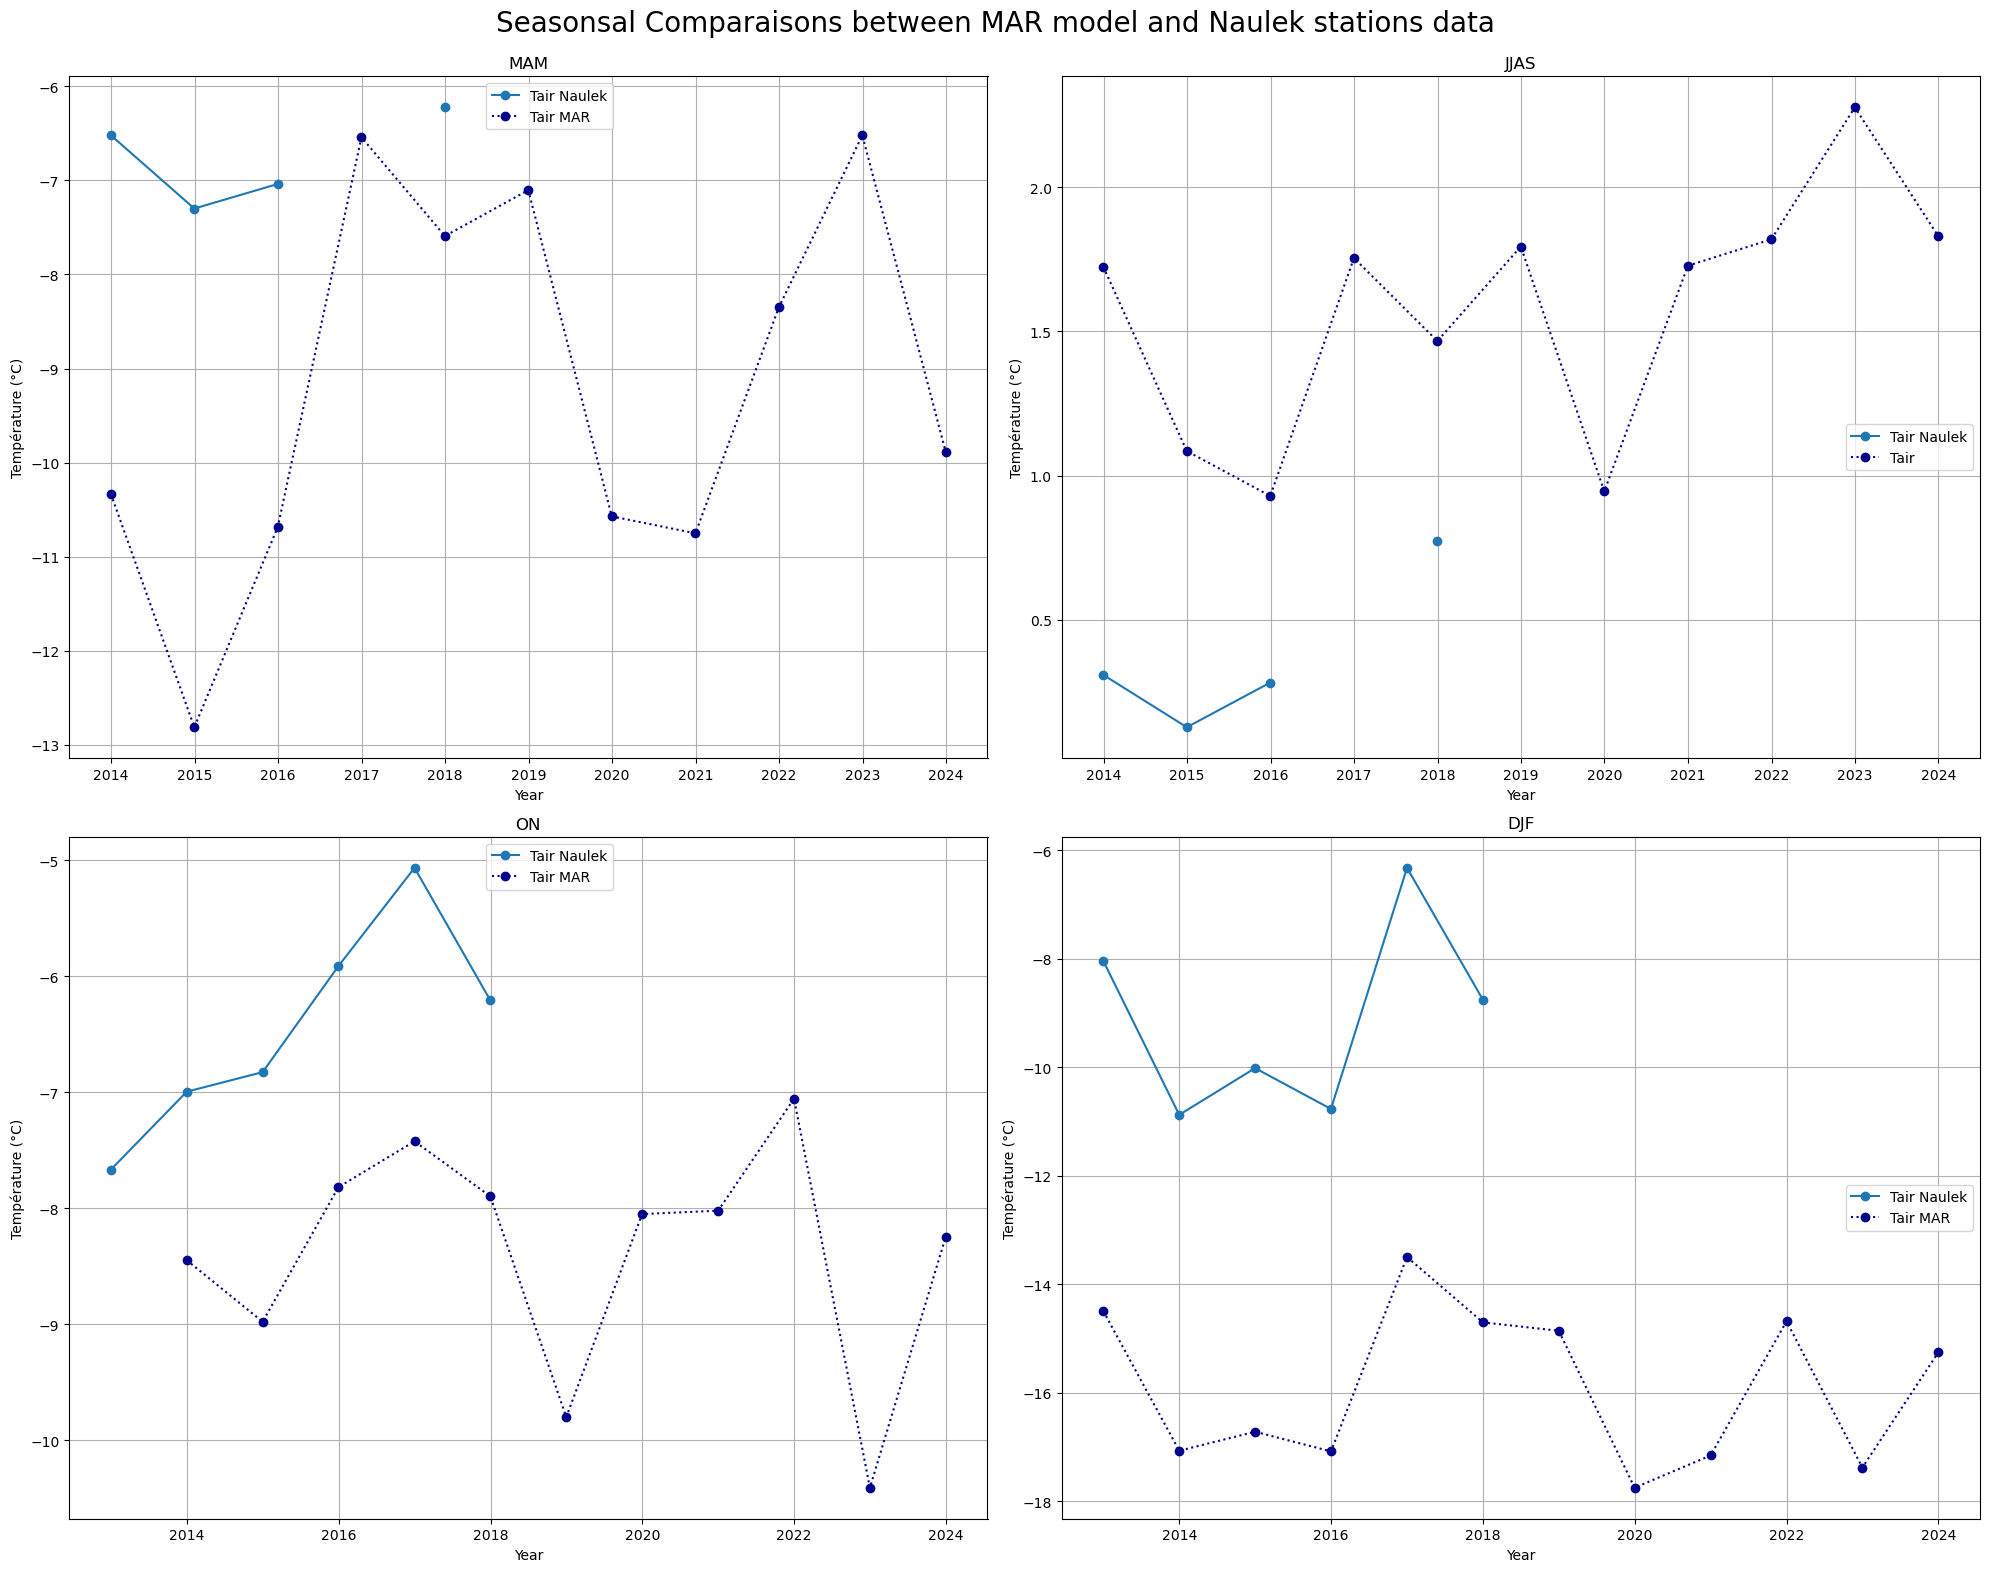

In [29]:
#Ajout incertitudes, 

fig, ((ax1,ax2) , (ax3,ax4)) = plt.subplots(2,2, figsize=(20,16))
ax1.plot(Timeseries_Tsta_premon.time, Timeseries_Tsta_premon['Tair'].values, linestyle='-', marker= 'o', label='Tair Naulek')
ax1.plot(Timeseries_TMAR_premon.time, Timeseries_TMAR_premon.values,color='darkblue', linestyle=':', marker= 'o', label='Tair MAR')


ax1.legend(bbox_to_anchor=(0.1, 0.5, 0.5, 0.5)) 
ax1.set_title('MAM')
ax1.set_xlabel('Year')
ax1.set_ylabel('Température (°C)')
ax1.grid()

ax2.plot(Timeseries_Tsta_mon.time, Timeseries_Tsta_mon['Tair'].values, linestyle='-', marker= 'o', label='Tair Naulek')
ax2.plot(Timeseries_TMAR_mon.time, Timeseries_TMAR_mon.values,color='darkblue', linestyle=':', marker= 'o', label='Tair')



ax2.legend(bbox_to_anchor=(0.5, 0, 0.5, 0.5)) 
ax2.set_title('JJAS')
ax2.set_xlabel('Year')
ax2.set_ylabel('Température (°C)')
ax2.grid()

ax3.plot(Timeseries_Tsta_postmon.time, Timeseries_Tsta_postmon['Tair'].values, linestyle='-', marker= 'o', label='Tair Naulek')
ax3.plot(Timeseries_TMAR_postmon.time, Timeseries_TMAR_postmon.values,color='darkblue', linestyle=':', marker= 'o', label='Tair MAR')



ax3.legend(bbox_to_anchor=(0.1, 0.5, 0.5, 0.5)) 
ax3.set_title('ON')
ax3.set_xlabel('Year')
ax3.set_ylabel('Température (°C)')
ax3.grid()

ax4.plot(Timeseries_Tsta_hiver.time, Timeseries_Tsta_hiver['Tair'].values, linestyle='-', marker= 'o', label='Tair Naulek')
ax4.plot(Timeseries_TMAR_hiver.time, Timeseries_TMAR_hiver.values,color='darkblue', linestyle=':', marker= 'o', label='Tair MAR')


ax4.legend(bbox_to_anchor=(0.5, 0, 0.5, 0.5)) 
ax4.set_title('DJF')
ax4.set_xlabel('Year')
ax4.set_ylabel('Température (°C)')
ax4.grid()


plt.tight_layout(rect=[0, 0, 1, 0.96])  # Maria script theft : leave space for the suptitle
fig.suptitle('Seasonsal Comparaisons between MAR model and Naulek stations data',fontsize=20)


fig, ((ax1,ax2) , (ax3,ax4)) = plt.subplots(2,2, figsize=(20,16))
ax1.plot(Timeseries_Tsta_premon.time, Timeseries_Tsta_premon['Tair'].values, linestyle=':', marker= 'o', label='Tair Station MeraLa')
ax1.plot(Timeseries_TMAR_premon.time, Timeseries_TMAR_premon.values,color='darkblue', linestyle=':', marker= 'o', label='Tair MAR')

ax1.plot(Timeseries_Tsta_premon.time, linTsta_premon.intercept + linTsta_premon.slope*xtime15_24, 'cyan', label='line regress Tair MeraLa')
ax1.plot(Timeseries_Tsta_premon.time, linTMAR_premon.intercept + linTMAR_premon.slope*xtime15_24, 'blue', label='line regress Tair MAR')

ax1.legend(bbox_to_anchor=(0.1, 0.5, 0.5, 0.5)) 
ax1.set_title('MAM')
ax1.set_xlabel('Month')
ax1.set_ylabel('Température (°C)')
ax1.grid()

ax2.plot(Timeseries_Tsta_mon.time, Timeseries_Tsta_mon['Tair'].values, linestyle=':', marker= 'o', label='Tair Station MeraLA')
ax2.plot(Timeseries_TMAR_mon.time, Timeseries_TMAR_mon.values,color='darkblue', linestyle=':', marker= 'o', label='Tair')

ax2.plot(Timeseries_Tsta_mon.time, linTsta_mon.intercept + linTsta_mon.slope*xtime15_24, 'cyan', label='line regress Tair MeraLa')
ax2.plot(Timeseries_TMAR_mon.time, linTMAR_mon.intercept + linTMAR_mon.slope*xtime15_24, 'blue', label='line regress Tair MAR')


ax2.legend(bbox_to_anchor=(0.5, 0, 0.5, 0.5)) 
ax2.set_title('JJAS')
ax2.set_xlabel('Month')
ax2.set_ylabel('Température (°C)')
ax2.grid()

ax3.plot(Timeseries_Tsta_postmon.time, Timeseries_Tsta_postmon['Tair'].values, linestyle=':', marker= 'o', label='Tair Station MeraLA')
ax3.plot(Timeseries_TMAR_postmon.time, Timeseries_TMAR_postmon.values,color='darkblue', linestyle=':', marker= 'o', label='Tair MAR')

ax3.plot(Timeseries_Tsta_postmon.time, linTsta_postmon.intercept + linTsta_postmon.slope*xtime14_24, 'cyan', label='line regress Tair MeraLa')
ax3.plot(Timeseries_TMAR_postmon.time, linTMAR_postmon.intercept + linTMAR_postmon.slope*xtime15_24, 'blue', label='line regress Tair MAR')


ax3.legend(bbox_to_anchor=(0.1, 0.5, 0.5, 0.5)) 
ax3.set_title('ON')
ax3.set_xlabel('Month')
ax3.set_ylabel('Température (°C)')
ax3.grid()

ax4.plot(Timeseries_Tsta_hiver.time, Timeseries_Tsta_hiver['Tair'].values, linestyle=':', marker= 'o', label='Tair Station MeraLA')
ax4.plot(Timeseries_TMAR_hiver.time, Timeseries_TMAR_hiver.values,color='darkblue', linestyle=':', marker= 'o', label='Tair MAR')

ax4.plot(Timeseries_Tsta_hiver.time, linTsta_hiver.intercept + linTsta_hiver.slope*xtime14_24, 'cyan', label='line regress Tair MeraLa')
ax4.plot(Timeseries_TMAR_hiver.time, linTMAR_hiver.intercept + linTMAR_hiver.slope*xtime14_24, 'blue', label='line regress Tair MAR')

ax4.legend(bbox_to_anchor=(0.5, 0, 0.5, 0.5)) 
ax4.set_title('DJF')
ax4.set_xlabel('Month')
ax4.set_ylabel('Température (°C)')
ax4.grid()


plt.tight_layout(rect=[0, 0, 1, 0.96])  # Maria script theft : leave space for the suptitle
fig.suptitle('Seasonsal Comparaisons between MAR model and MeraLa stations data',fontsize=20)

In [30]:
#print('différence dT/dt entre données sta et model MAR :',linTsta_premon.slope-linTMAR_premon.slope, linTsta_mon.slope-linTMAR_mon.slope, linTsta_postmon.slope-linTMAR_postmon.slope, linTsta_hiver.slope-linTMAR_hiver.slope)